## Jonathan Alvarez - DATA 695 - Model Development
### 10-22-2023

## Background
### The goal of this project is to build a model than can effectively predict obesity. This data set was taken from the publicly available UC Irvine Machine Learning Repository. The exploratory data analysis phase has been completed prior to Model Development.  

In [1]:
#Import Dependencies
import pandas as pd
import numpy as np 

# data visualization
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

# Algorithms
from sklearn import decomposition, preprocessing
from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold, KFold, GridSearchCV, cross_val_score,learning_curve
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn import linear_model, tree
from sklearn.linear_model import LogisticRegression,Perceptron,SGDClassifier,LassoCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from scikeras.wrappers import KerasClassifier

data = pd.read_csv("C:/Users/jonal/OneDrive/Documents/FranklinU/DATA695/Pre-ML.csv")

def grouplabels(row):
    ''' This function is used to group labels into 3 classifications (Insufficient/Normal Weight | Overweight | Obese)  '''

    if row['NObeyesdad'] == 'Normal_Weight':
        return 'Normalweight'
    elif  row['NObeyesdad'] == 'Insufficient_Weight':
        return 'Normalweight' 
    elif 'Overweight' in row['NObeyesdad'] :
        return 'Overweight' 
    elif 'Obesity' in row['NObeyesdad']:
        return 'Obese'
    else:
        return row['NObeyesdad']
    

### With a multi classification problem, the more classes the more difficult it may be to predict a class. Since the problem scope is to effectively predict Obesity, the 7 classes can probably be consolidated. During the exploratory data analysis, we confirmed no concern of an imbalanced set of classes. A visualization has been created to demonstrate the balanced data set. 

Text(0, 0.5, 'Quantity of Records')

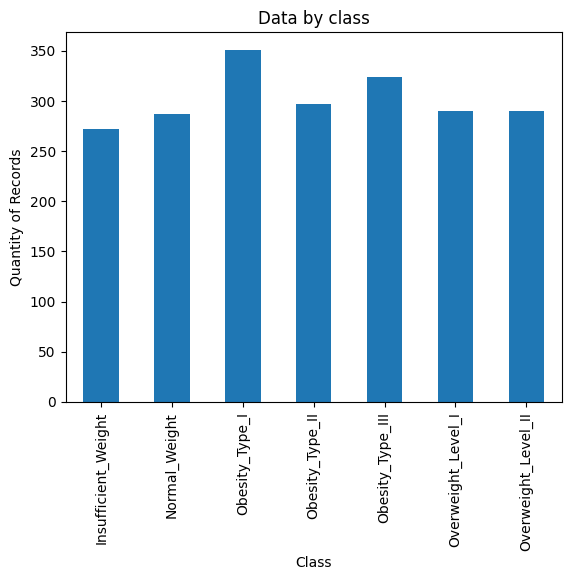

In [2]:
data.groupby(['NObeyesdad']).size().plot.bar()

plt.title('Data by class')
plt.xlabel('Class')
plt.ylabel('Quantity of Records')

Text(0, 0.5, 'Quantity of Records')

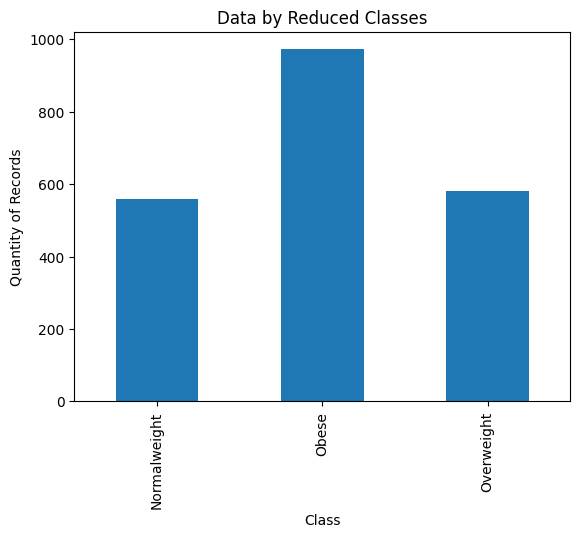

In [3]:
# In order to reduce the complexity in predicted classes. The classes will be reduced to 3 classes (Normal Weight, Obese or overweight)
data['NObeyesdad'] = data.apply(grouplabels, axis =1)
data.groupby(['NObeyesdad']).size().plot.bar()


plt.title('Data by Reduced Classes')
plt.xlabel('Class')
plt.ylabel('Quantity of Records')

In [4]:
tempdf = data.groupby(['NObeyesdad']).size().reset_index(name = 'Grpcnt')
tempdf['prop'] = tempdf['Grpcnt']/len(data.index)

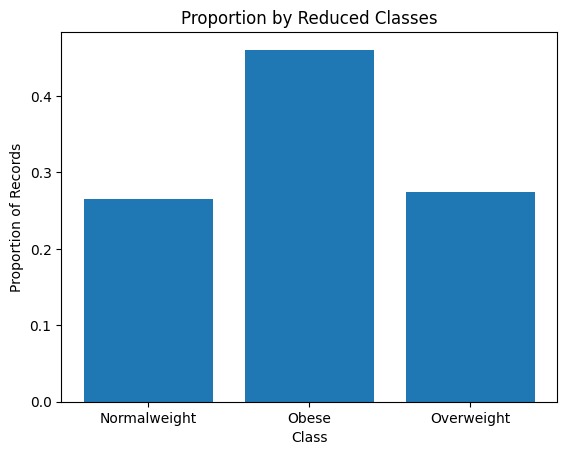

In [5]:
propdf = tempdf[['NObeyesdad','prop']]
plt.bar(tempdf['NObeyesdad'], tempdf['prop'])
plt.title('Proportion by Reduced Classes')
plt.xlabel('Class')
plt.ylabel('Proportion of Records')
plt.show()

### With the reduction of classes we can see that the obese class is roughly 25% higher than the other classes however there is enough data between normal weight & overweight class to bring no concern for imbalanced classes

## Baseline Model
### Let's begin building a predictive model. This Decision Tree Classifier can be treated as the "baseline" model

In [6]:
pcadf = data.iloc[:,0:16]
dftarget = data.iloc[:,16:17]

X = pcadf
y = dftarget

Text(0.5, 1.0, 'Confusion Matrix')

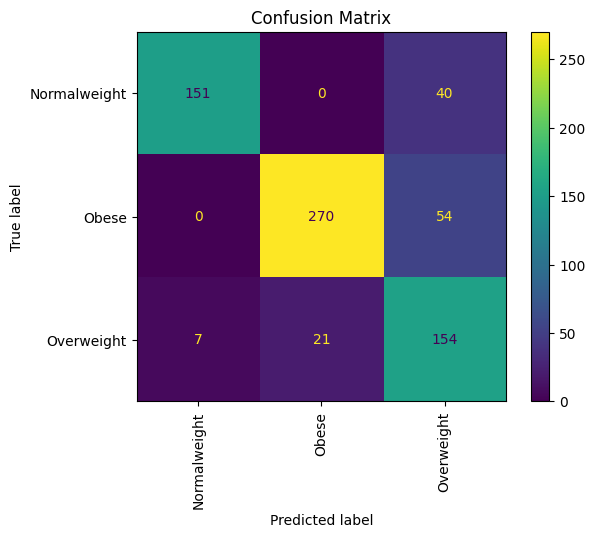

In [7]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)
  
# training a DescisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=dtree_model.classes_)
disp.plot()
plt.xticks(rotation = 90)
plt.title('Baseline Confusion Matrix')

### The confusion matrix depicts a high accuracy in predicting the obese class

In [8]:
# Print classification report due to having multiple classes
print(classification_report(y_test, dtree_predictions))

              precision    recall  f1-score   support

Normalweight       0.96      0.79      0.87       191
       Obese       0.93      0.83      0.88       324
  Overweight       0.62      0.85      0.72       182

    accuracy                           0.82       697
   macro avg       0.83      0.82      0.82       697
weighted avg       0.86      0.82      0.83       697



### Another metric is to understand the f1-score and weighted average score across classes. Scores tend to sit around 83%

## Gaussian Naiive Bayes Model

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Confusion Matrix')

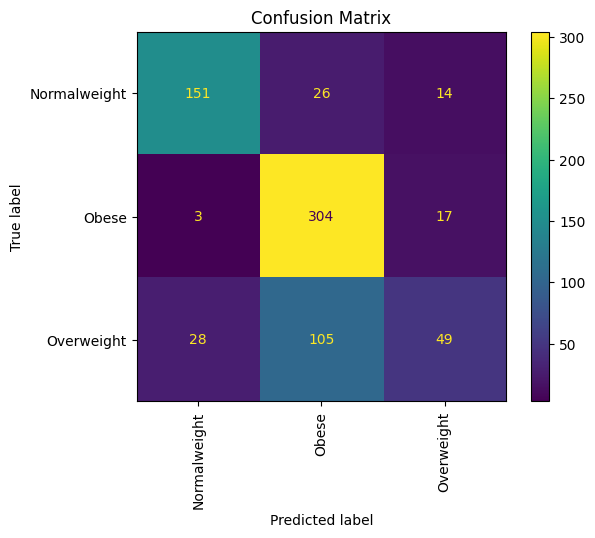

In [9]:
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
  
 
# creating a confusion matrix
cm_nb = confusion_matrix(y_test, gnb_predictions)

nb_disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb,  display_labels=gnb.classes_)
nb_disp.plot()
plt.xticks(rotation = 90)
plt.title('GNB Confusion Matrix')

### The Gaussian NB model demonstrates a similar accuracy to the baseline with high accuracy for the obese class. However the overweight class does bring more false positives

In [10]:
print(classification_report(y_test, gnb_predictions))

              precision    recall  f1-score   support

Normalweight       0.83      0.79      0.81       191
       Obese       0.70      0.94      0.80       324
  Overweight       0.61      0.27      0.37       182

    accuracy                           0.72       697
   macro avg       0.71      0.67      0.66       697
weighted avg       0.71      0.72      0.69       697



### Focusing on the f1-score, the Gaussian NB does perform worse with an accuracy of 72% and with a weighted average of 69%

## Keras Neural Network Model

In [11]:
# Create model here
model = Sequential()
model.add(Dense(9, input_dim = 16, activation = 'relu')) # Rectified Linear Unit Activation Function
model.add(Dense(9, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))              # Softmax for multi-class classification
# Compile model here
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 153       
                                                                 
 dense_1 (Dense)             (None, 9)                 90        
                                                                 
 dense_2 (Dense)             (None, 3)                 30        
                                                                 
Total params: 273 (1.07 KB)
Trainable params: 273 (1.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Label Encode from strings
label_encoder = preprocessing.LabelEncoder()
yy = label_encoder.fit_transform( data['NObeyesdad'])
y['NObeyesdad'] = yy

# Using keras to categorical to ensure proper format
y_cat = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.33, random_state = 0)

C:\Users\jonal\AppData\Local\Temp\ipykernel_26524\3691183883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['NObeyesdad'] = yy


In [13]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=100)

Epoch 1/100
 4/15 [=======>......................] - ETA: 0s - loss: 25.2989 - accuracy: 0.2650

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 0s 23ms/step - loss: 24.1344 - accuracy: 0.2603 - val_loss: 21.5125 - val_accuracy: 0.2740
Epoch 2/100
 9/15 [=================>............] - ETA: 0s - loss: 20.9329 - accuracy: 0.2578

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 0s 20ms/step - loss: 20.0700 - accuracy: 0.2603 - val_loss: 17.5553 - val_accuracy: 0.2740
Epoch 3/100
15/15 [==============================] - 0s 21ms/step - loss: 15.9945 - accuracy: 0.2603 - val_loss: 13.5383 - val_accuracy: 0.2740
Epoch 4/100
15/15 [==============================] - 0s 22ms/step - loss: 11.9359 - accuracy: 0.2603 - val_loss: 9.5346 - val_accuracy: 0.2740
Epoch 5/100
15/15 [==============================] - 0s 19ms/step - loss: 7.9051 - accuracy: 0.2581 - val_loss: 5.6917 - val_accuracy: 0.2697
Epoch 6/100
15/15 [==============================] - 0s 21ms/step - loss: 4.3778 - accuracy: 0.2037 - val_loss: 3.0755 - val_accuracy: 0.1607
Epoch 7/100
15/15 [==============================] - 0s 21ms/step - loss: 2.4781 - accuracy: 0.2023 - val_loss: 2.0491 - val_accuracy: 0.2367
Epoch 8/100
15/15 [==============================] - 0s 21ms/step - loss: 1.7915 - accuracy: 0.2539 - val_loss: 1.6387 - val_accuracy: 0.3142
Epoch 9/100
1

22/22 [==============================] - 0s 2ms/step


c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Text(0.5, 1.0, 'Neural Network Confusion Matrix')

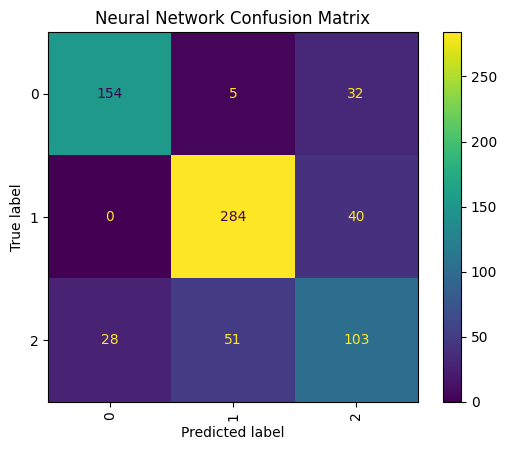

In [14]:
y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(model.predict(x_test), axis=-1)

# creating a confusion matrix
cm_seq = confusion_matrix(y_test_class, y_pred_class)

seq_disp = ConfusionMatrixDisplay(confusion_matrix=cm_seq,  display_labels=np.unique(y_pred_class))
seq_disp.plot()
plt.xticks(rotation = 90)
plt.title('Neural Network Confusion Matrix')

### The Neural Network model seems to perform better than the Gaussian however marginally better than the decision tree. Neural Networks tend to have a higher chance of overfitting. For this reason we will exercise a GridSearchCV to try and improve the performance.

In [17]:
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       191
           1       0.84      0.88      0.86       324
           2       0.59      0.57      0.58       182

    accuracy                           0.78       697
   macro avg       0.76      0.75      0.75       697
weighted avg       0.77      0.78      0.77       697



## Best Neural Network (GridSearchCV Applied)

### The next steps is to apply GridSearchCV to optimize the neural network parameters. This is definitely time consuming so there are a few parameters we will try.

In [18]:
def build_clf(unit): 
  # creating the layers of the ANN 
  model = Sequential()
  model.add(Dense(9, input_dim = 16, activation = 'relu')) # Rectified Linear Unit Activation Function
  model.add(Dense(9, activation = 'relu'))
  model.add(Dense(3, activation = 'softmax'))              # Softmax for multi-class classification
  # Compile model here
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return (model)

# Call class
model=KerasClassifier(build_fn=build_clf, unit = 2)

# Grid Search CV for ANN
params={'batch_size':[50, 25, 75],  
        'epochs':[50, 25, 75], 
        'unit':[5,6, 10],      
        } 

gs=GridSearchCV(estimator=model, param_grid=params, cv=2)   

# now fit the dataset to the GridSearchCV object.  
gs = gs.fit(X, y_cat)

best_params=gs.best_params_ 
accuracy=gs.best_score_

Epoch 1/50
 8/22 [=========>....................] - ETA: 0s - loss: 18.5449 - accuracy: 0.0000e+00

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 0s 15ms/step - loss: 12.8803 - accuracy: 0.0275
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 2.1324 - accuracy: 0.7100
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 1.5780 - accuracy: 0.8550
Epoch 4/50
22/22 [==============================] - 0s 17ms/step - loss: 1.2399 - accuracy: 0.8550
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.8774 - accuracy: 0.8540
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.5902 - accuracy: 0.8493
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.4542 - accuracy: 0.8531
Epoch 8/50
22/22 [==============================] - 0s 14ms/step - loss: 0.4222 - accuracy: 0.8550
Epoch 9/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3958 - accuracy: 0.8550
Epoch 10/50
22/22 [==============================] - 0s 13ms/step - loss: 0.3791 - accuracy: 0.8550
Epoch 11/50
22/22 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 16ms/step - loss: 7.6386 - accuracy: 0.5294
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 3.3338 - accuracy: 0.4347
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 1.7599 - accuracy: 0.3305
Epoch 4/50
22/22 [==============================] - 0s 16ms/step - loss: 1.5022 - accuracy: 0.2879
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 1.2979 - accuracy: 0.3646
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 1.1550 - accuracy: 0.4527
Epoch 7/50
22/22 [==============================] - 0s 16ms/step - loss: 1.0424 - accuracy: 0.5180
Epoch 8/50
22/22 [==============================] - 0s 16ms/step - loss: 0.9612 - accuracy: 0.5625
Epoch 9/50
22/22 [==============================] - 0s 14ms/step - loss: 0.8893 - accuracy: 0.6089
Epoch 10/50
22/22 [==============================] - 0s 13ms/step - loss: 0.8252 - accuracy: 0.6581
Epoch 11/50
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 15ms/step - loss: 2.2552 - accuracy: 0.8104
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.0098 - accuracy: 0.8199
Epoch 3/50
22/22 [==============================] - 0s 20ms/step - loss: 0.4082 - accuracy: 0.8502
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3423 - accuracy: 0.8512
Epoch 5/50
22/22 [==============================] - 0s 15ms/step - loss: 0.3216 - accuracy: 0.8370
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3147 - accuracy: 0.8464
Epoch 7/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3094 - accuracy: 0.8445
Epoch 8/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3056 - accuracy: 0.8351
Epoch 9/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3038 - accuracy: 0.8474
Epoch 10/50
22/22 [==============================] - 0s 14ms/step - loss: 0.3028 - accuracy: 0.8483
Epoch 11/50
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 14ms/step - loss: 21.8188 - accuracy: 0.4044
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 14.4602 - accuracy: 0.4044
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 8.5636 - accuracy: 0.3542
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 4.9338 - accuracy: 0.3040
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 2.0575 - accuracy: 0.3352
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 1.0003 - accuracy: 0.5729
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.9763 - accuracy: 0.5871
Epoch 8/50
22/22 [==============================] - 0s 12ms/step - loss: 0.9572 - accuracy: 0.5843
Epoch 9/50
22/22 [==============================] - 0s 13ms/step - loss: 0.9416 - accuracy: 0.6061
Epoch 10/50
22/22 [==============================] - 0s 13ms/step - loss: 0.9370 - accuracy: 0.6051
Epoch 11/50
22/22 

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 13ms/step - loss: 1.6864 - accuracy: 0.7877
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 1.2299 - accuracy: 0.8550
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.9332 - accuracy: 0.8550
Epoch 4/50
22/22 [==============================] - 0s 15ms/step - loss: 0.7527 - accuracy: 0.8550
Epoch 5/50
22/22 [==============================] - 0s 16ms/step - loss: 0.6269 - accuracy: 0.8550
Epoch 6/50
22/22 [==============================] - 0s 15ms/step - loss: 0.5305 - accuracy: 0.8550
Epoch 7/50
22/22 [==============================] - 0s 15ms/step - loss: 0.4613 - accuracy: 0.8550
Epoch 8/50
22/22 [==============================] - 0s 14ms/step - loss: 0.4119 - accuracy: 0.8550
Epoch 9/50
22/22 [==============================] - 0s 12ms/step - loss: 0.3736 - accuracy: 0.8550
Epoch 10/50
22/22 [==============================] - 0s 12ms/step - loss: 0.3437 - accuracy: 0.8550
Epoch 11/50
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 1s 23ms/step - loss: 11.6986 - accuracy: 0.5294
Epoch 2/50
22/22 [==============================] - 0s 19ms/step - loss: 6.4061 - accuracy: 0.5322
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 2.0999 - accuracy: 0.5634
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 1.1074 - accuracy: 0.5066
Epoch 5/50
22/22 [==============================] - 0s 13ms/step - loss: 0.9766 - accuracy: 0.6439
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.9418 - accuracy: 0.6562
Epoch 7/50
22/22 [==============================] - 0s 12ms/step - loss: 0.9293 - accuracy: 0.6231
Epoch 8/50
22/22 [==============================] - 0s 15ms/step - loss: 0.9085 - accuracy: 0.6657
Epoch 9/50
22/22 [==============================] - 0s 13ms/step - loss: 0.8890 - accuracy: 0.6638
Epoch 10/50
22/22 [==============================] - 0s 16ms/step - loss: 0.8722 - accuracy: 0.6799
Epoch 11/50
22/22 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 13ms/step - loss: 10.1175 - accuracy: 0.0123
Epoch 2/25
22/22 [==============================] - 0s 12ms/step - loss: 2.7192 - accuracy: 0.8076
Epoch 3/25
22/22 [==============================] - 0s 13ms/step - loss: 1.4444 - accuracy: 0.8550
Epoch 4/25
22/22 [==============================] - 0s 14ms/step - loss: 0.4977 - accuracy: 0.8550
Epoch 5/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3665 - accuracy: 0.8550
Epoch 6/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3468 - accuracy: 0.8550
Epoch 7/25
22/22 [==============================] - 0s 16ms/step - loss: 0.3355 - accuracy: 0.8550
Epoch 8/25
22/22 [==============================] - 0s 13ms/step - loss: 0.3274 - accuracy: 0.8550
Epoch 9/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3209 - accuracy: 0.8550
Epoch 10/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3148 - accuracy: 0.8550
Epoch 11/25
22/22 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 12ms/step - loss: 12.4253 - accuracy: 0.2093
Epoch 2/25
22/22 [==============================] - 0s 13ms/step - loss: 8.8037 - accuracy: 0.3248
Epoch 3/25
22/22 [==============================] - 0s 13ms/step - loss: 5.7097 - accuracy: 0.3097
Epoch 4/25
22/22 [==============================] - 0s 12ms/step - loss: 2.7913 - accuracy: 0.3684
Epoch 5/25
22/22 [==============================] - 0s 13ms/step - loss: 1.0354 - accuracy: 0.3892
Epoch 6/25
22/22 [==============================] - 0s 13ms/step - loss: 0.9221 - accuracy: 0.3883
Epoch 7/25
22/22 [==============================] - 0s 13ms/step - loss: 0.8951 - accuracy: 0.4356
Epoch 8/25
22/22 [==============================] - 0s 13ms/step - loss: 0.8699 - accuracy: 0.4943
Epoch 9/25
22/22 [==============================] - 0s 12ms/step - loss: 0.8543 - accuracy: 0.5407
Epoch 10/25
22/22 [==============================] - 0s 12ms/step - loss: 0.8387 - accuracy: 0.5919
Epoch 11/25
22/22 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 12ms/step - loss: 92.9419 - accuracy: 0.0000e+00
Epoch 2/25
22/22 [==============================] - 0s 12ms/step - loss: 68.5699 - accuracy: 0.0000e+00
Epoch 3/25
22/22 [==============================] - 0s 12ms/step - loss: 44.5209 - accuracy: 0.0000e+00
Epoch 4/25
22/22 [==============================] - 0s 12ms/step - loss: 21.5044 - accuracy: 0.0209
Epoch 5/25
22/22 [==============================] - 0s 13ms/step - loss: 7.0930 - accuracy: 0.0910
Epoch 6/25
22/22 [==============================] - 0s 13ms/step - loss: 1.0282 - accuracy: 0.7318
Epoch 7/25
22/22 [==============================] - 0s 13ms/step - loss: 0.7078 - accuracy: 0.8076
Epoch 8/25
22/22 [==============================] - 0s 13ms/step - loss: 0.5504 - accuracy: 0.8095
Epoch 9/25
22/22 [==============================] - 0s 13ms/step - loss: 0.4714 - accuracy: 0.8123
Epoch 10/25
22/22 [==============================] - 0s 12ms/step - loss: 0.4317 - accuracy: 0.8237
Epoc

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 15ms/step - loss: 1.1480 - accuracy: 0.3381
Epoch 2/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9845 - accuracy: 0.3911
Epoch 3/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9623 - accuracy: 0.3797
Epoch 4/25
22/22 [==============================] - 0s 13ms/step - loss: 0.9557 - accuracy: 0.4366
Epoch 5/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9473 - accuracy: 0.4773
Epoch 6/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9368 - accuracy: 0.4943
Epoch 7/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9277 - accuracy: 0.5871
Epoch 8/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9211 - accuracy: 0.6051
Epoch 9/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9098 - accuracy: 0.6222
Epoch 10/25
22/22 [==============================] - 0s 13ms/step - loss: 0.9068 - accuracy: 0.6269
Epoch 11/25
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 15ms/step - loss: 0.4043 - accuracy: 0.8569
Epoch 2/25
22/22 [==============================] - 0s 15ms/step - loss: 0.3710 - accuracy: 0.8550
Epoch 3/25
22/22 [==============================] - 0s 13ms/step - loss: 0.3467 - accuracy: 0.8483
Epoch 4/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3293 - accuracy: 0.8540
Epoch 5/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3303 - accuracy: 0.8540
Epoch 6/25
22/22 [==============================] - 0s 13ms/step - loss: 0.3197 - accuracy: 0.8588
Epoch 7/25
22/22 [==============================] - 0s 13ms/step - loss: 0.3196 - accuracy: 0.8626
Epoch 8/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3141 - accuracy: 0.8597
Epoch 9/25
22/22 [==============================] - 0s 12ms/step - loss: 0.3166 - accuracy: 0.8588
Epoch 10/25
22/22 [==============================] - 0s 11ms/step - loss: 0.3145 - accuracy: 0.8664
Epoch 11/25
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 13ms/step - loss: 2.5880 - accuracy: 0.5294
Epoch 2/25
22/22 [==============================] - 0s 12ms/step - loss: 1.3644 - accuracy: 0.5294
Epoch 3/25
22/22 [==============================] - 0s 13ms/step - loss: 1.0595 - accuracy: 0.4602
Epoch 4/25
22/22 [==============================] - 0s 13ms/step - loss: 1.0136 - accuracy: 0.4650
Epoch 5/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9888 - accuracy: 0.4991
Epoch 6/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9605 - accuracy: 0.5691
Epoch 7/25
22/22 [==============================] - 0s 12ms/step - loss: 0.9241 - accuracy: 0.6477
Epoch 8/25
22/22 [==============================] - 0s 12ms/step - loss: 0.8924 - accuracy: 0.6894
Epoch 9/25
22/22 [==============================] - 0s 12ms/step - loss: 0.8754 - accuracy: 0.6970
Epoch 10/25
22/22 [==============================] - 0s 12ms/step - loss: 0.8636 - accuracy: 0.7027
Epoch 11/25
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 14ms/step - loss: 2.3978 - accuracy: 0.4114
Epoch 2/75
22/22 [==============================] - 0s 12ms/step - loss: 0.8768 - accuracy: 0.8550
Epoch 3/75
22/22 [==============================] - 0s 15ms/step - loss: 0.7560 - accuracy: 0.8550
Epoch 4/75
22/22 [==============================] - 0s 12ms/step - loss: 0.6546 - accuracy: 0.8550
Epoch 5/75
22/22 [==============================] - 0s 12ms/step - loss: 0.5981 - accuracy: 0.8540
Epoch 6/75
22/22 [==============================] - 0s 13ms/step - loss: 0.5342 - accuracy: 0.8550
Epoch 7/75
22/22 [==============================] - 0s 12ms/step - loss: 0.4551 - accuracy: 0.8550
Epoch 8/75
22/22 [==============================] - 0s 12ms/step - loss: 0.3892 - accuracy: 0.8559
Epoch 9/75
22/22 [==============================] - 0s 12ms/step - loss: 0.3641 - accuracy: 0.8597
Epoch 10/75
22/22 [==============================] - 0s 12ms/step - loss: 0.3572 - accuracy: 0.8607
Epoch 11/75
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 12ms/step - loss: 2.0716 - accuracy: 0.3665
Epoch 2/75
22/22 [==============================] - 0s 12ms/step - loss: 1.3460 - accuracy: 0.3485
Epoch 3/75
22/22 [==============================] - 0s 12ms/step - loss: 1.0325 - accuracy: 0.6553
Epoch 4/75
22/22 [==============================] - 0s 12ms/step - loss: 0.9984 - accuracy: 0.6771
Epoch 5/75
22/22 [==============================] - 0s 13ms/step - loss: 0.9762 - accuracy: 0.6856
Epoch 6/75
22/22 [==============================] - 0s 12ms/step - loss: 0.9571 - accuracy: 0.7131
Epoch 7/75
22/22 [==============================] - 0s 15ms/step - loss: 0.9353 - accuracy: 0.6913
Epoch 8/75
22/22 [==============================] - 0s 12ms/step - loss: 0.9052 - accuracy: 0.7045
Epoch 9/75
22/22 [==============================] - 0s 15ms/step - loss: 0.8807 - accuracy: 0.7188
Epoch 10/75
22/22 [==============================] - 0s 12ms/step - loss: 0.8576 - accuracy: 0.7254
Epoch 11/75
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 15ms/step - loss: 1.3698 - accuracy: 0.8493
Epoch 2/75
22/22 [==============================] - 0s 16ms/step - loss: 0.4435 - accuracy: 0.8218
Epoch 3/75
22/22 [==============================] - 0s 14ms/step - loss: 0.4243 - accuracy: 0.8313
Epoch 4/75
22/22 [==============================] - 0s 13ms/step - loss: 0.3767 - accuracy: 0.8332
Epoch 5/75
22/22 [==============================] - 0s 13ms/step - loss: 0.3609 - accuracy: 0.8341
Epoch 6/75
22/22 [==============================] - 0s 13ms/step - loss: 0.3367 - accuracy: 0.8379
Epoch 7/75
22/22 [==============================] - 0s 13ms/step - loss: 0.3246 - accuracy: 0.8303
Epoch 8/75
22/22 [==============================] - 0s 12ms/step - loss: 0.3082 - accuracy: 0.8417
Epoch 9/75
22/22 [==============================] - 0s 14ms/step - loss: 0.3133 - accuracy: 0.8370
Epoch 10/75
22/22 [==============================] - 0s 13ms/step - loss: 0.3089 - accuracy: 0.8436
Epoch 11/75
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 14ms/step - loss: 1.0430 - accuracy: 0.3769
Epoch 2/75
22/22 [==============================] - 0s 15ms/step - loss: 0.9488 - accuracy: 0.4290
Epoch 3/75
22/22 [==============================] - 0s 13ms/step - loss: 0.8702 - accuracy: 0.5540
Epoch 4/75
22/22 [==============================] - 0s 16ms/step - loss: 0.7362 - accuracy: 0.6951
Epoch 5/75
22/22 [==============================] - 0s 13ms/step - loss: 0.6530 - accuracy: 0.7386
Epoch 6/75
22/22 [==============================] - 0s 14ms/step - loss: 0.6209 - accuracy: 0.7623
Epoch 7/75
22/22 [==============================] - 0s 17ms/step - loss: 0.5955 - accuracy: 0.7775
Epoch 8/75
22/22 [==============================] - 0s 13ms/step - loss: 0.5806 - accuracy: 0.7945
Epoch 9/75
22/22 [==============================] - 0s 15ms/step - loss: 0.5659 - accuracy: 0.7888
Epoch 10/75
22/22 [==============================] - 0s 16ms/step - loss: 0.5570 - accuracy: 0.7917
Epoch 11/75
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 13ms/step - loss: 34.2995 - accuracy: 0.1450
Epoch 2/75
22/22 [==============================] - 0s 12ms/step - loss: 23.7629 - accuracy: 0.1450
Epoch 3/75
22/22 [==============================] - 0s 12ms/step - loss: 16.8730 - accuracy: 0.1450
Epoch 4/75
22/22 [==============================] - 0s 12ms/step - loss: 12.2443 - accuracy: 0.1450
Epoch 5/75
22/22 [==============================] - 0s 13ms/step - loss: 8.9464 - accuracy: 0.1450
Epoch 6/75
22/22 [==============================] - 0s 13ms/step - loss: 6.6128 - accuracy: 0.1450
Epoch 7/75
22/22 [==============================] - 0s 13ms/step - loss: 4.9578 - accuracy: 0.1450
Epoch 8/75
22/22 [==============================] - 0s 13ms/step - loss: 3.7364 - accuracy: 0.1450
Epoch 9/75
22/22 [==============================] - 0s 12ms/step - loss: 2.8373 - accuracy: 0.1450
Epoch 10/75
22/22 [==============================] - 0s 12ms/step - loss: 2.1797 - accuracy: 0.1450
Epoch 11/75
22/2

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

22/22 [==============================] - 0s 16ms/step - loss: 3.0224 - accuracy: 0.0795
Epoch 2/75
22/22 [==============================] - 0s 12ms/step - loss: 1.8715 - accuracy: 0.2699
Epoch 3/75
22/22 [==============================] - 0s 13ms/step - loss: 1.5243 - accuracy: 0.4498
Epoch 4/75
22/22 [==============================] - 0s 12ms/step - loss: 1.3513 - accuracy: 0.4943
Epoch 5/75
22/22 [==============================] - 0s 12ms/step - loss: 1.2475 - accuracy: 0.5227
Epoch 6/75
22/22 [==============================] - 0s 15ms/step - loss: 1.1776 - accuracy: 0.5265
Epoch 7/75
22/22 [==============================] - 0s 12ms/step - loss: 1.1208 - accuracy: 0.5294
Epoch 8/75
22/22 [==============================] - 0s 12ms/step - loss: 1.0521 - accuracy: 0.5294
Epoch 9/75
22/22 [==============================] - 0s 12ms/step - loss: 0.9990 - accuracy: 0.5303
Epoch 10/75
22/22 [==============================] - 0s 12ms/step - loss: 0.9505 - accuracy: 0.5294
Epoch 11/75
22/22 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 12ms/step - loss: 0.5725 - accuracy: 0.8531
Epoch 2/50
43/43 [==============================] - 1s 12ms/step - loss: 0.3533 - accuracy: 0.8635
Epoch 3/50
43/43 [==============================] - 1s 12ms/step - loss: 0.2875 - accuracy: 0.8787
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 0.2713 - accuracy: 0.8787
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 0.2609 - accuracy: 0.8900
Epoch 6/50
43/43 [==============================] - 1s 14ms/step - loss: 0.2455 - accuracy: 0.8815
Epoch 7/50
43/43 [==============================] - 1s 12ms/step - loss: 0.2385 - accuracy: 0.8938
Epoch 8/50
43/43 [==============================] - 1s 14ms/step - loss: 0.2598 - accuracy: 0.8806
Epoch 9/50
43/43 [==============================] - 1s 12ms/step - loss: 0.2275 - accuracy: 0.9005
Epoch 10/50
43/43 [==============================] - 1s 14ms/step - loss: 0.2344 - accuracy: 0.8872
Epoch 11/50
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 2.4327 - accuracy: 0.3693
Epoch 2/50
43/43 [==============================] - 1s 12ms/step - loss: 1.0778 - accuracy: 0.5133
Epoch 3/50
43/43 [==============================] - 1s 15ms/step - loss: 0.9446 - accuracy: 0.5540
Epoch 4/50
43/43 [==============================] - 1s 12ms/step - loss: 0.8713 - accuracy: 0.6127
Epoch 5/50
43/43 [==============================] - 1s 12ms/step - loss: 0.8096 - accuracy: 0.6667
Epoch 6/50
43/43 [==============================] - 1s 12ms/step - loss: 0.7641 - accuracy: 0.6856
Epoch 7/50
43/43 [==============================] - 1s 12ms/step - loss: 0.7224 - accuracy: 0.7216
Epoch 8/50
43/43 [==============================] - 1s 16ms/step - loss: 0.6871 - accuracy: 0.7528
Epoch 9/50
43/43 [==============================] - 1s 14ms/step - loss: 0.6634 - accuracy: 0.7642
Epoch 10/50
43/43 [==============================] - 1s 14ms/step - loss: 0.6351 - accuracy: 0.7775
Epoch 11/50
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50


c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


43/43 [==============================] - 1s 15ms/step - loss: 0.6038 - accuracy: 0.7611
Epoch 2/50
43/43 [==============================] - 1s 14ms/step - loss: 0.4625 - accuracy: 0.8550
Epoch 3/50
43/43 [==============================] - 1s 14ms/step - loss: 0.4310 - accuracy: 0.8550
Epoch 4/50
43/43 [==============================] - 1s 18ms/step - loss: 0.4070 - accuracy: 0.8550
Epoch 5/50
43/43 [==============================] - 1s 19ms/step - loss: 0.3657 - accuracy: 0.8569
Epoch 6/50
43/43 [==============================] - 1s 14ms/step - loss: 0.3261 - accuracy: 0.8588
Epoch 7/50
43/43 [==============================] - 1s 15ms/step - loss: 0.3021 - accuracy: 0.8720
Epoch 8/50
43/43 [==============================] - 1s 15ms/step - loss: 0.2832 - accuracy: 0.8749
Epoch 9/50
43/43 [==============================] - 1s 16ms/step - loss: 0.2721 - accuracy: 0.8796
Epoch 10/50
43/43 [==============================] - 1s 13ms/step - loss: 0.2682 - accuracy: 0.8796
Epoch 11/50
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 14ms/step - loss: 11.5214 - accuracy: 0.0663
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 3.7187 - accuracy: 0.1733
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 2.3372 - accuracy: 0.3674
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 1.7454 - accuracy: 0.3769
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 1.3527 - accuracy: 0.4025
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1219 - accuracy: 0.4081
Epoch 7/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9976 - accuracy: 0.4223
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9348 - accuracy: 0.4205
Epoch 9/50
43/43 [==============================] - 1s 14ms/step - loss: 0.9030 - accuracy: 0.4167
Epoch 10/50
43/43 [==============================] - 1s 15ms/step - loss: 0.8871 - accuracy: 0.3570
Epoch 11/50
43/43 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 14ms/step - loss: 13.6141 - accuracy: 0.8550
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 8.4098 - accuracy: 0.8550
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 4.9817 - accuracy: 0.8550
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 2.1333 - accuracy: 0.8550
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 0.5792 - accuracy: 0.8417
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 0.4946 - accuracy: 0.8607
Epoch 7/50
43/43 [==============================] - 1s 13ms/step - loss: 0.4408 - accuracy: 0.8578
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 0.3933 - accuracy: 0.8607
Epoch 9/50
43/43 [==============================] - 1s 13ms/step - loss: 0.3595 - accuracy: 0.8654
Epoch 10/50
43/43 [==============================] - 1s 13ms/step - loss: 0.3215 - accuracy: 0.8664
Epoch 11/50
43/43 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 1.1711 - accuracy: 0.4025
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 1.0343 - accuracy: 0.6098
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9900 - accuracy: 0.5843
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9503 - accuracy: 0.6051
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9095 - accuracy: 0.6278
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 0.8597 - accuracy: 0.6316
Epoch 7/50
43/43 [==============================] - 1s 13ms/step - loss: 0.8036 - accuracy: 0.6723
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 0.7550 - accuracy: 0.6847
Epoch 9/50
43/43 [==============================] - 1s 13ms/step - loss: 0.7138 - accuracy: 0.6866
Epoch 10/50
43/43 [==============================] - 1s 13ms/step - loss: 0.6827 - accuracy: 0.6922
Epoch 11/50
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 1.3929 - accuracy: 0.8521
Epoch 2/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3507 - accuracy: 0.8341
Epoch 3/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3004 - accuracy: 0.8626
Epoch 4/25
43/43 [==============================] - 1s 13ms/step - loss: 0.2980 - accuracy: 0.8616
Epoch 5/25
43/43 [==============================] - 1s 13ms/step - loss: 0.2867 - accuracy: 0.8578
Epoch 6/25
43/43 [==============================] - 1s 14ms/step - loss: 0.2881 - accuracy: 0.8607
Epoch 7/25
43/43 [==============================] - 1s 14ms/step - loss: 0.2865 - accuracy: 0.8578
Epoch 8/25
43/43 [==============================] - 1s 14ms/step - loss: 0.2783 - accuracy: 0.8692
Epoch 9/25
43/43 [==============================] - 1s 14ms/step - loss: 0.2717 - accuracy: 0.8654
Epoch 10/25
43/43 [==============================] - 1s 15ms/step - loss: 0.2672 - accuracy: 0.8730
Epoch 11/25
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 2.1757 - accuracy: 0.3807
Epoch 2/25
43/43 [==============================] - 1s 14ms/step - loss: 1.0511 - accuracy: 0.4848
Epoch 3/25
43/43 [==============================] - 1s 13ms/step - loss: 0.9086 - accuracy: 0.5947
Epoch 4/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8811 - accuracy: 0.6231
Epoch 5/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8255 - accuracy: 0.6458
Epoch 6/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8072 - accuracy: 0.6544
Epoch 7/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7585 - accuracy: 0.7150
Epoch 8/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7352 - accuracy: 0.6989
Epoch 9/25
43/43 [==============================] - 1s 13ms/step - loss: 0.6941 - accuracy: 0.7509
Epoch 10/25
43/43 [==============================] - 1s 13ms/step - loss: 0.6709 - accuracy: 0.7670
Epoch 11/25
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 0.4922 - accuracy: 0.7488
Epoch 2/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3719 - accuracy: 0.8550
Epoch 3/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3399 - accuracy: 0.8550
Epoch 4/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3222 - accuracy: 0.8550
Epoch 5/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3130 - accuracy: 0.8550
Epoch 6/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3078 - accuracy: 0.8512
Epoch 7/25
43/43 [==============================] - 1s 13ms/step - loss: 0.3063 - accuracy: 0.8578
Epoch 8/25
43/43 [==============================] - 1s 13ms/step - loss: 0.2999 - accuracy: 0.8559
Epoch 9/25
43/43 [==============================] - 1s 13ms/step - loss: 0.2966 - accuracy: 0.8635
Epoch 10/25
43/43 [==============================] - 1s 13ms/step - loss: 0.2873 - accuracy: 0.8588
Epoch 11/25
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 5.3273 - accuracy: 0.3864
Epoch 2/25
43/43 [==============================] - 1s 13ms/step - loss: 1.2591 - accuracy: 0.3608
Epoch 3/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8414 - accuracy: 0.7273
Epoch 4/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7716 - accuracy: 0.7595
Epoch 5/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7276 - accuracy: 0.7604
Epoch 6/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7070 - accuracy: 0.7727
Epoch 7/25
43/43 [==============================] - 1s 13ms/step - loss: 0.6919 - accuracy: 0.7775
Epoch 8/25
43/43 [==============================] - 1s 13ms/step - loss: 0.6814 - accuracy: 0.7727
Epoch 9/25
43/43 [==============================] - 1s 13ms/step - loss: 0.6702 - accuracy: 0.7803
Epoch 10/25
43/43 [==============================] - 1s 13ms/step - loss: 0.6605 - accuracy: 0.7850
Epoch 11/25
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 1.0777 - accuracy: 0.8351
Epoch 2/25
43/43 [==============================] - 1s 12ms/step - loss: 1.0361 - accuracy: 0.8550
Epoch 3/25
43/43 [==============================] - 1s 12ms/step - loss: 0.9966 - accuracy: 0.8550
Epoch 4/25
43/43 [==============================] - 1s 12ms/step - loss: 0.9594 - accuracy: 0.8550
Epoch 5/25
43/43 [==============================] - 1s 12ms/step - loss: 0.9242 - accuracy: 0.8550
Epoch 6/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8910 - accuracy: 0.8550
Epoch 7/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8602 - accuracy: 0.8550
Epoch 8/25
43/43 [==============================] - 1s 16ms/step - loss: 0.8314 - accuracy: 0.8550
Epoch 9/25
43/43 [==============================] - 1s 13ms/step - loss: 0.8047 - accuracy: 0.8550
Epoch 10/25
43/43 [==============================] - 1s 12ms/step - loss: 0.7801 - accuracy: 0.8550
Epoch 11/25
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 12ms/step - loss: 2.9282 - accuracy: 0.4167
Epoch 2/25
43/43 [==============================] - 1s 13ms/step - loss: 0.9416 - accuracy: 0.5691
Epoch 3/25
43/43 [==============================] - 1s 14ms/step - loss: 0.8896 - accuracy: 0.6042
Epoch 4/25
43/43 [==============================] - 1s 12ms/step - loss: 0.8672 - accuracy: 0.6127
Epoch 5/25
43/43 [==============================] - 1s 12ms/step - loss: 0.8389 - accuracy: 0.6364
Epoch 6/25
43/43 [==============================] - 1s 12ms/step - loss: 0.8055 - accuracy: 0.6733
Epoch 7/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7774 - accuracy: 0.6932
Epoch 8/25
43/43 [==============================] - 1s 14ms/step - loss: 0.7551 - accuracy: 0.7188
Epoch 9/25
43/43 [==============================] - 1s 18ms/step - loss: 0.7291 - accuracy: 0.7169
Epoch 10/25
43/43 [==============================] - 1s 13ms/step - loss: 0.7075 - accuracy: 0.7301
Epoch 11/25
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

Epoch 1/75
43/43 [==============================] - 1s 12ms/step - loss: 8.8526 - accuracy: 0.0000e+00
Epoch 2/75
43/43 [==============================] - 1s 13ms/step - loss: 4.3942 - accuracy: 0.0000e+00
Epoch 3/75
43/43 [==============================] - 1s 16ms/step - loss: 2.3467 - accuracy: 0.0000e+00
Epoch 4/75
43/43 [==============================] - 1s 12ms/step - loss: 1.4319 - accuracy: 0.2047
Epoch 5/75
43/43 [==============================] - 1s 13ms/step - loss: 1.0437 - accuracy: 0.8550
Epoch 6/75
43/43 [==============================] - 1s 13ms/step - loss: 0.8425 - accuracy: 0.8550
Epoch 7/75
43/43 [==============================] - 1s 13ms/step - loss: 0.7123 - accuracy: 0.8550
Epoch 8/75
43/43 [==============================] - 1s 12ms/step - loss: 0.6222 - accuracy: 0.8550
Epoch 9/75
43/43 [==============================] - 1s 13ms/step - loss: 0.5544 - accuracy: 0.8550
Epoch 10/75
43/43 [==============================] - 1s 14ms/step - loss: 0.4952 - accuracy: 0.85

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 3.3082 - accuracy: 0.4044
Epoch 2/75
43/43 [==============================] - 1s 12ms/step - loss: 1.4311 - accuracy: 0.4100
Epoch 3/75
43/43 [==============================] - 1s 12ms/step - loss: 0.8944 - accuracy: 0.6098
Epoch 4/75
43/43 [==============================] - 1s 12ms/step - loss: 0.8116 - accuracy: 0.6525
Epoch 5/75
43/43 [==============================] - 1s 12ms/step - loss: 0.7664 - accuracy: 0.6629
Epoch 6/75
43/43 [==============================] - 1s 12ms/step - loss: 0.7117 - accuracy: 0.6799
Epoch 7/75
43/43 [==============================] - 1s 12ms/step - loss: 0.6731 - accuracy: 0.6989
Epoch 8/75
43/43 [==============================] - 1s 12ms/step - loss: 0.6341 - accuracy: 0.7150
Epoch 9/75
43/43 [==============================] - 1s 12ms/step - loss: 0.6047 - accuracy: 0.7358
Epoch 10/75
43/43 [==============================] - 1s 12ms/step - loss: 0.5824 - accuracy: 0.7557
Epoch 11/75
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 13ms/step - loss: 0.7155 - accuracy: 0.8550
Epoch 2/75
43/43 [==============================] - 1s 12ms/step - loss: 0.3760 - accuracy: 0.8550
Epoch 3/75
43/43 [==============================] - 1s 12ms/step - loss: 0.3404 - accuracy: 0.8550
Epoch 4/75
43/43 [==============================] - 1s 12ms/step - loss: 0.3306 - accuracy: 0.8559
Epoch 5/75
43/43 [==============================] - 1s 12ms/step - loss: 0.3131 - accuracy: 0.8559
Epoch 6/75
43/43 [==============================] - 1s 12ms/step - loss: 0.3080 - accuracy: 0.8578
Epoch 7/75
43/43 [==============================] - 1s 12ms/step - loss: 0.3020 - accuracy: 0.8521
Epoch 8/75
43/43 [==============================] - 1s 12ms/step - loss: 0.2975 - accuracy: 0.8626
Epoch 9/75
43/43 [==============================] - 1s 13ms/step - loss: 0.2917 - accuracy: 0.8645
Epoch 10/75
43/43 [==============================] - 1s 12ms/step - loss: 0.2817 - accuracy: 0.8626
Epoch 11/75
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 12ms/step - loss: 8.1675 - accuracy: 0.3239
Epoch 2/75
43/43 [==============================] - 1s 12ms/step - loss: 1.7160 - accuracy: 0.4621
Epoch 3/75
43/43 [==============================] - 1s 13ms/step - loss: 0.9844 - accuracy: 0.5549
Epoch 4/75
43/43 [==============================] - 1s 12ms/step - loss: 0.9486 - accuracy: 0.5739
Epoch 5/75
43/43 [==============================] - 1s 12ms/step - loss: 0.9132 - accuracy: 0.5814
Epoch 6/75
43/43 [==============================] - 1s 12ms/step - loss: 0.8815 - accuracy: 0.5871
Epoch 7/75
43/43 [==============================] - 1s 12ms/step - loss: 0.8519 - accuracy: 0.6250
Epoch 8/75
43/43 [==============================] - 1s 12ms/step - loss: 0.8301 - accuracy: 0.6174
Epoch 9/75
43/43 [==============================] - 1s 13ms/step - loss: 0.8072 - accuracy: 0.6506
Epoch 10/75
43/43 [==============================] - 1s 12ms/step - loss: 0.7901 - accuracy: 0.6525
Epoch 11/75
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

Epoch 1/75
43/43 [==============================] - 1s 14ms/step - loss: 0.7092 - accuracy: 0.7261
Epoch 2/75
43/43 [==============================] - 1s 13ms/step - loss: 0.4475 - accuracy: 0.8550
Epoch 3/75
43/43 [==============================] - 1s 14ms/step - loss: 0.4095 - accuracy: 0.8550
Epoch 4/75
43/43 [==============================] - 1s 14ms/step - loss: 0.3700 - accuracy: 0.8550
Epoch 5/75
43/43 [==============================] - 1s 14ms/step - loss: 0.3438 - accuracy: 0.8550
Epoch 6/75
43/43 [==============================] - 1s 13ms/step - loss: 0.3318 - accuracy: 0.8550
Epoch 7/75
43/43 [==============================] - 1s 14ms/step - loss: 0.3182 - accuracy: 0.8464
Epoch 8/75
43/43 [==============================] - 1s 14ms/step - loss: 0.3142 - accuracy: 0.8398
Epoch 9/75
43/43 [==============================] - 1s 15ms/step - loss: 0.3067 - accuracy: 0.8483
Epoch 10/75
43/43 [==============================] - 1s 15ms/step - loss: 0.3043 - accuracy: 0.8398
Epoch 11/

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

43/43 [==============================] - 1s 16ms/step - loss: 1.7295 - accuracy: 0.3949
Epoch 2/75
43/43 [==============================] - 1s 16ms/step - loss: 0.9861 - accuracy: 0.5407
Epoch 3/75
43/43 [==============================] - 1s 14ms/step - loss: 0.9346 - accuracy: 0.5938
Epoch 4/75
43/43 [==============================] - 1s 14ms/step - loss: 0.9177 - accuracy: 0.5814
Epoch 5/75
43/43 [==============================] - 1s 13ms/step - loss: 0.9093 - accuracy: 0.6269
Epoch 6/75
43/43 [==============================] - 1s 14ms/step - loss: 0.9011 - accuracy: 0.6231
Epoch 7/75
43/43 [==============================] - 1s 13ms/step - loss: 0.8927 - accuracy: 0.6562
Epoch 8/75
43/43 [==============================] - 1s 14ms/step - loss: 0.8841 - accuracy: 0.6705
Epoch 9/75
43/43 [==============================] - 1s 14ms/step - loss: 0.8718 - accuracy: 0.6799
Epoch 10/75
43/43 [==============================] - 1s 14ms/step - loss: 0.8605 - accuracy: 0.6913
Epoch 11/75
43/43 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

Epoch 1/50
15/15 [==============================] - 0s 18ms/step - loss: 31.8791 - accuracy: 0.1052
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 19.5411 - accuracy: 0.0825
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 8.3171 - accuracy: 0.0464
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 1.1069 - accuracy: 0.6398
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.9371 - accuracy: 0.8550
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 0.7306 - accuracy: 0.8550
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 0.5980 - accuracy: 0.8313
Epoch 8/50
15/15 [==============================] - 0s 16ms/step - loss: 0.5004 - accuracy: 0.8408
Epoch 9/50
15/15 [==============================] - 0s 16ms/step - loss: 0.4440 - accuracy: 0.8246
Epoch 10/50
15/15 [==============================] - 0s 18ms/step - loss: 0.4105 - accuracy: 0.8389
Epoch 1

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 19ms/step - loss: 12.0160 - accuracy: 0.4044
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 8.7165 - accuracy: 0.4044
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 5.6282 - accuracy: 0.4044
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 2.4220 - accuracy: 0.4744
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 1.7644 - accuracy: 0.5568
Epoch 6/50
15/15 [==============================] - 0s 20ms/step - loss: 1.3942 - accuracy: 0.6278
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 1.1370 - accuracy: 0.6468
Epoch 8/50
15/15 [==============================] - 0s 17ms/step - loss: 0.9618 - accuracy: 0.6638
Epoch 9/50
15/15 [==============================] - 0s 17ms/step - loss: 0.8802 - accuracy: 0.6847
Epoch 10/50
15/15 [==============================] - 0s 17ms/step - loss: 0.8708 - accuracy: 0.6922
Epoch 11/50
15/15 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 23ms/step - loss: 48.3883 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 14ms/step - loss: 33.9470 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 20.9831 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 16ms/step - loss: 8.9403 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 1.6072 - accuracy: 0.7156
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 1.4501 - accuracy: 0.8550
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 1.0755 - accuracy: 0.8550
Epoch 8/50
15/15 [==============================] - 0s 16ms/step - loss: 0.6198 - accuracy: 0.8550
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 0.4451 - accuracy: 0.8588
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 0.4101 - accuracy: 0.8559
E

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 15ms/step - loss: 2.1376 - accuracy: 0.5294
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 1.2162 - accuracy: 0.5294
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 0.9920 - accuracy: 0.5294
Epoch 4/50
15/15 [==============================] - 0s 14ms/step - loss: 0.9600 - accuracy: 0.5294
Epoch 5/50
15/15 [==============================] - 0s 14ms/step - loss: 0.9382 - accuracy: 0.5294
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 0.9164 - accuracy: 0.5350
Epoch 7/50
15/15 [==============================] - 0s 15ms/step - loss: 0.8957 - accuracy: 0.5587
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 0.8747 - accuracy: 0.6136
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 0.8560 - accuracy: 0.6600
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 0.8387 - accuracy: 0.6979
Epoch 11/50
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 15ms/step - loss: 68.7813 - accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 14ms/step - loss: 55.2927 - accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 43.5108 - accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 14ms/step - loss: 33.3004 - accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 24.2688 - accuracy: 0.0019
Epoch 6/50
15/15 [==============================] - 0s 14ms/step - loss: 15.7584 - accuracy: 0.0360
Epoch 7/50
15/15 [==============================] - 0s 14ms/step - loss: 8.7048 - accuracy: 0.1289
Epoch 8/50
15/15 [==============================] - 0s 14ms/step - loss: 3.7350 - accuracy: 0.1782
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 1.2809 - accuracy: 0.5744
Epoch 10/50
15/15 [==============================] - 0s 14ms/step - loss: 0.9060 - accuracy: 0.810

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 18ms/step - loss: 21.9644 - accuracy: 0.0663
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 17.0541 - accuracy: 0.0663
Epoch 3/50
15/15 [==============================] - 0s 14ms/step - loss: 13.0099 - accuracy: 0.0663
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 10.3932 - accuracy: 0.2661
Epoch 5/50
15/15 [==============================] - 0s 23ms/step - loss: 8.7335 - accuracy: 0.3542
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 7.3423 - accuracy: 0.3267
Epoch 7/50
15/15 [==============================] - 0s 21ms/step - loss: 6.1404 - accuracy: 0.3239
Epoch 8/50
15/15 [==============================] - 0s 21ms/step - loss: 5.1252 - accuracy: 0.3438
Epoch 9/50
15/15 [==============================] - 0s 24ms/step - loss: 4.2418 - accuracy: 0.3494
Epoch 10/50
15/15 [==============================] - 0s 21ms/step - loss: 3.4673 - accuracy: 0.3494
Epoch 11/50
15/1

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 18ms/step - loss: 23.7436 - accuracy: 0.0000e+00
Epoch 2/25
15/15 [==============================] - 0s 18ms/step - loss: 16.8198 - accuracy: 0.0000e+00
Epoch 3/25
15/15 [==============================] - 0s 18ms/step - loss: 10.7565 - accuracy: 0.0000e+00
Epoch 4/25
15/15 [==============================] - 0s 17ms/step - loss: 5.4895 - accuracy: 0.0000e+00
Epoch 5/25
15/15 [==============================] - 0s 18ms/step - loss: 1.5100 - accuracy: 0.3488
Epoch 6/25
15/15 [==============================] - 0s 17ms/step - loss: 0.4812 - accuracy: 0.8550
Epoch 7/25
15/15 [==============================] - 0s 17ms/step - loss: 0.4580 - accuracy: 0.8550
Epoch 8/25
15/15 [==============================] - 0s 19ms/step - loss: 0.4082 - accuracy: 0.8550
Epoch 9/25
15/15 [==============================] - 0s 21ms/step - loss: 0.3979 - accuracy: 0.8550
Epoch 10/25
15/15 [==============================] - 0s 15ms/step - loss: 0.3924 - accuracy: 0.8550
E

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 18ms/step - loss: 11.1933 - accuracy: 0.4044
Epoch 2/25
15/15 [==============================] - 0s 17ms/step - loss: 8.7332 - accuracy: 0.4044
Epoch 3/25
15/15 [==============================] - 0s 18ms/step - loss: 6.7085 - accuracy: 0.4044
Epoch 4/25
15/15 [==============================] - 0s 17ms/step - loss: 5.0638 - accuracy: 0.4044
Epoch 5/25
15/15 [==============================] - 0s 16ms/step - loss: 3.7446 - accuracy: 0.4044
Epoch 6/25
15/15 [==============================] - 0s 16ms/step - loss: 2.6709 - accuracy: 0.4044
Epoch 7/25
15/15 [==============================] - 0s 18ms/step - loss: 1.8809 - accuracy: 0.4044
Epoch 8/25
15/15 [==============================] - 0s 19ms/step - loss: 1.3357 - accuracy: 0.4044
Epoch 9/25
15/15 [==============================] - 0s 17ms/step - loss: 1.0741 - accuracy: 0.4044
Epoch 10/25
15/15 [==============================] - 0s 17ms/step - loss: 1.0101 - accuracy: 0.4044
Epoch 11/25
15/15 [

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 21ms/step - loss: 0.4284 - accuracy: 0.8512
Epoch 2/25
15/15 [==============================] - 0s 16ms/step - loss: 0.3567 - accuracy: 0.8502
Epoch 3/25
15/15 [==============================] - 0s 17ms/step - loss: 0.3280 - accuracy: 0.8493
Epoch 4/25
15/15 [==============================] - 0s 16ms/step - loss: 0.3190 - accuracy: 0.8597
Epoch 5/25
15/15 [==============================] - 0s 16ms/step - loss: 0.3134 - accuracy: 0.8578
Epoch 6/25
15/15 [==============================] - 0s 16ms/step - loss: 0.2962 - accuracy: 0.8616
Epoch 7/25
15/15 [==============================] - 0s 17ms/step - loss: 0.2892 - accuracy: 0.8730
Epoch 8/25
15/15 [==============================] - 0s 17ms/step - loss: 0.2919 - accuracy: 0.8692
Epoch 9/25
15/15 [==============================] - 0s 17ms/step - loss: 0.2811 - accuracy: 0.8701
Epoch 10/25
15/15 [==============================] - 0s 17ms/step - loss: 0.2736 - accuracy: 0.8701
Epoch 11/25
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 20ms/step - loss: 3.3519 - accuracy: 0.4044
Epoch 2/25
15/15 [==============================] - 0s 19ms/step - loss: 2.1997 - accuracy: 0.4044
Epoch 3/25
15/15 [==============================] - 0s 17ms/step - loss: 1.0451 - accuracy: 0.5540
Epoch 4/25
15/15 [==============================] - 0s 17ms/step - loss: 0.7312 - accuracy: 0.6610
Epoch 5/25
15/15 [==============================] - 0s 17ms/step - loss: 0.6963 - accuracy: 0.7642
Epoch 6/25
15/15 [==============================] - 0s 16ms/step - loss: 0.6822 - accuracy: 0.7775
Epoch 7/25
15/15 [==============================] - 0s 17ms/step - loss: 0.6736 - accuracy: 0.7623
Epoch 8/25
15/15 [==============================] - 0s 21ms/step - loss: 0.6646 - accuracy: 0.7803
Epoch 9/25
15/15 [==============================] - 0s 17ms/step - loss: 0.6583 - accuracy: 0.7670
Epoch 10/25
15/15 [==============================] - 0s 17ms/step - loss: 0.6526 - accuracy: 0.7812
Epoch 11/25
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 17ms/step - loss: 2.1678 - accuracy: 0.1460
Epoch 2/25
15/15 [==============================] - 0s 16ms/step - loss: 0.4479 - accuracy: 0.8455
Epoch 3/25
15/15 [==============================] - 0s 17ms/step - loss: 0.4357 - accuracy: 0.8550
Epoch 4/25
15/15 [==============================] - 0s 17ms/step - loss: 0.4205 - accuracy: 0.8550
Epoch 5/25
15/15 [==============================] - 0s 18ms/step - loss: 0.3930 - accuracy: 0.8550
Epoch 6/25
15/15 [==============================] - 0s 16ms/step - loss: 0.3850 - accuracy: 0.8550
Epoch 7/25
15/15 [==============================] - 0s 19ms/step - loss: 0.3800 - accuracy: 0.8550
Epoch 8/25
15/15 [==============================] - 0s 18ms/step - loss: 0.3745 - accuracy: 0.8550
Epoch 9/25
15/15 [==============================] - 0s 19ms/step - loss: 0.3696 - accuracy: 0.8550
Epoch 10/25
15/15 [==============================] - 0s 18ms/step - loss: 0.3636 - accuracy: 0.8550
Epoch 11/25
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 18ms/step - loss: 7.9917 - accuracy: 0.5294
Epoch 2/25
15/15 [==============================] - 0s 18ms/step - loss: 4.2301 - accuracy: 0.5294
Epoch 3/25
15/15 [==============================] - 0s 17ms/step - loss: 1.8861 - accuracy: 0.3864
Epoch 4/25
15/15 [==============================] - 0s 16ms/step - loss: 1.4928 - accuracy: 0.4905
Epoch 5/25
15/15 [==============================] - 0s 17ms/step - loss: 1.3272 - accuracy: 0.5606
Epoch 6/25
15/15 [==============================] - 0s 17ms/step - loss: 1.2521 - accuracy: 0.5625
Epoch 7/25
15/15 [==============================] - 0s 17ms/step - loss: 1.1816 - accuracy: 0.5464
Epoch 8/25
15/15 [==============================] - 0s 20ms/step - loss: 1.1294 - accuracy: 0.5511
Epoch 9/25
15/15 [==============================] - 0s 19ms/step - loss: 1.0829 - accuracy: 0.5606
Epoch 10/25
15/15 [==============================] - 0s 17ms/step - loss: 1.0437 - accuracy: 0.5597
Epoch 11/25
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 21ms/step - loss: 3.7308 - accuracy: 0.3223
Epoch 2/75
15/15 [==============================] - 0s 19ms/step - loss: 1.4596 - accuracy: 0.7706
Epoch 3/75
15/15 [==============================] - 0s 17ms/step - loss: 1.4070 - accuracy: 0.8436
Epoch 4/75
15/15 [==============================] - 0s 17ms/step - loss: 1.2763 - accuracy: 0.8209
Epoch 5/75
15/15 [==============================] - 0s 17ms/step - loss: 1.1444 - accuracy: 0.7829
Epoch 6/75
15/15 [==============================] - 0s 18ms/step - loss: 0.9046 - accuracy: 0.7915
Epoch 7/75
15/15 [==============================] - 0s 17ms/step - loss: 0.6273 - accuracy: 0.7867
Epoch 8/75
15/15 [==============================] - 0s 17ms/step - loss: 0.5205 - accuracy: 0.8294
Epoch 9/75
15/15 [==============================] - 0s 18ms/step - loss: 0.4517 - accuracy: 0.8512
Epoch 10/75
15/15 [==============================] - 0s 18ms/step - loss: 0.3713 - accuracy: 0.8512
Epoch 11/75
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 21ms/step - loss: 4.7177 - accuracy: 0.4394
Epoch 2/75
15/15 [==============================] - 0s 19ms/step - loss: 2.3934 - accuracy: 0.2178
Epoch 3/75
15/15 [==============================] - 0s 19ms/step - loss: 1.2217 - accuracy: 0.5426
Epoch 4/75
15/15 [==============================] - 0s 19ms/step - loss: 0.8755 - accuracy: 0.6648
Epoch 5/75
15/15 [==============================] - 0s 17ms/step - loss: 0.8426 - accuracy: 0.6809
Epoch 6/75
15/15 [==============================] - 0s 18ms/step - loss: 0.8094 - accuracy: 0.7008
Epoch 7/75
15/15 [==============================] - 0s 17ms/step - loss: 0.7923 - accuracy: 0.7027
Epoch 8/75
15/15 [==============================] - 0s 17ms/step - loss: 0.7665 - accuracy: 0.7102
Epoch 9/75
15/15 [==============================] - 0s 19ms/step - loss: 0.7442 - accuracy: 0.7178
Epoch 10/75
15/15 [==============================] - 0s 17ms/step - loss: 0.7291 - accuracy: 0.7254
Epoch 11/75
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 18ms/step - loss: 10.3196 - accuracy: 0.0000e+00
Epoch 2/75
15/15 [==============================] - 0s 18ms/step - loss: 5.9929 - accuracy: 0.0000e+00
Epoch 3/75
15/15 [==============================] - 0s 17ms/step - loss: 2.8294 - accuracy: 0.0844
Epoch 4/75
15/15 [==============================] - 0s 17ms/step - loss: 1.5654 - accuracy: 0.7706
Epoch 5/75
15/15 [==============================] - 0s 17ms/step - loss: 1.3123 - accuracy: 0.8550
Epoch 6/75
15/15 [==============================] - 0s 17ms/step - loss: 1.1256 - accuracy: 0.8550
Epoch 7/75
15/15 [==============================] - 0s 17ms/step - loss: 0.9596 - accuracy: 0.8550
Epoch 8/75
15/15 [==============================] - 0s 17ms/step - loss: 0.8193 - accuracy: 0.8550
Epoch 9/75
15/15 [==============================] - 0s 17ms/step - loss: 0.7120 - accuracy: 0.8550
Epoch 10/75
15/15 [==============================] - 0s 16ms/step - loss: 0.6315 - accuracy: 0.8550
Epoch 11/75

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 17ms/step - loss: 3.2784 - accuracy: 0.5294
Epoch 2/75
15/15 [==============================] - 0s 20ms/step - loss: 2.1247 - accuracy: 0.5294
Epoch 3/75
15/15 [==============================] - 0s 18ms/step - loss: 1.3838 - accuracy: 0.5294
Epoch 4/75
15/15 [==============================] - 0s 17ms/step - loss: 1.0439 - accuracy: 0.5104
Epoch 5/75
15/15 [==============================] - 0s 20ms/step - loss: 0.9867 - accuracy: 0.3987
Epoch 6/75
15/15 [==============================] - 0s 24ms/step - loss: 0.9800 - accuracy: 0.3977
Epoch 7/75
15/15 [==============================] - 0s 19ms/step - loss: 0.9619 - accuracy: 0.5114
Epoch 8/75
15/15 [==============================] - 0s 17ms/step - loss: 0.9499 - accuracy: 0.6373
Epoch 9/75
15/15 [==============================] - 0s 17ms/step - loss: 0.9382 - accuracy: 0.6506
Epoch 10/75
15/15 [==============================] - 0s 17ms/step - loss: 0.9253 - accuracy: 0.6884
Epoch 11/75
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 27ms/step - loss: 23.5242 - accuracy: 0.1450
Epoch 2/75
15/15 [==============================] - 0s 17ms/step - loss: 15.3547 - accuracy: 0.1403
Epoch 3/75
15/15 [==============================] - 0s 18ms/step - loss: 8.7386 - accuracy: 0.0341
Epoch 4/75
15/15 [==============================] - 0s 16ms/step - loss: 3.5887 - accuracy: 0.1043
Epoch 5/75
15/15 [==============================] - 0s 16ms/step - loss: 0.9097 - accuracy: 0.7118
Epoch 6/75
15/15 [==============================] - 0s 17ms/step - loss: 0.5418 - accuracy: 0.8417
Epoch 7/75
15/15 [==============================] - 0s 17ms/step - loss: 0.4469 - accuracy: 0.8550
Epoch 8/75
15/15 [==============================] - 0s 20ms/step - loss: 0.4112 - accuracy: 0.8559
Epoch 9/75
15/15 [==============================] - 0s 18ms/step - loss: 0.3903 - accuracy: 0.8569
Epoch 10/75
15/15 [==============================] - 0s 17ms/step - loss: 0.3750 - accuracy: 0.8540
Epoch 11/75
15/15 

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

15/15 [==============================] - 0s 14ms/step - loss: 4.6957 - accuracy: 0.3504
Epoch 2/75
15/15 [==============================] - 0s 13ms/step - loss: 1.9176 - accuracy: 0.5540
Epoch 3/75
15/15 [==============================] - 0s 13ms/step - loss: 1.6902 - accuracy: 0.5994
Epoch 4/75
15/15 [==============================] - 0s 13ms/step - loss: 1.6049 - accuracy: 0.5767
Epoch 5/75
15/15 [==============================] - 0s 13ms/step - loss: 1.5324 - accuracy: 0.6250
Epoch 6/75
15/15 [==============================] - 0s 13ms/step - loss: 1.4876 - accuracy: 0.6004
Epoch 7/75
15/15 [==============================] - 0s 15ms/step - loss: 1.4373 - accuracy: 0.6127
Epoch 8/75
15/15 [==============================] - 0s 14ms/step - loss: 1.3764 - accuracy: 0.6269
Epoch 9/75
15/15 [==============================] - 0s 14ms/step - loss: 1.3072 - accuracy: 0.6316
Epoch 10/75
15/15 [==============================] - 0s 16ms/step - loss: 1.2080 - accuracy: 0.6373
Epoch 11/75
15/15 [=

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply 

Epoch 1/50
85/85 [==============================] - 2s 20ms/step - loss: 2.1653 - accuracy: 0.4884
Epoch 2/50
85/85 [==============================] - 2s 19ms/step - loss: 0.9888 - accuracy: 0.5443
Epoch 3/50
85/85 [==============================] - 2s 20ms/step - loss: 0.9106 - accuracy: 0.5505
Epoch 4/50
85/85 [==============================] - 2s 21ms/step - loss: 0.8631 - accuracy: 0.5609
Epoch 5/50
85/85 [==============================] - 2s 21ms/step - loss: 0.8287 - accuracy: 0.5760
Epoch 6/50
85/85 [==============================] - 2s 20ms/step - loss: 0.8001 - accuracy: 0.5803
Epoch 7/50
85/85 [==============================] - 2s 20ms/step - loss: 0.7686 - accuracy: 0.5950
Epoch 8/50
85/85 [==============================] - 2s 20ms/step - loss: 0.7391 - accuracy: 0.5973
Epoch 9/50
85/85 [==============================] - 2s 22ms/step - loss: 0.7031 - accuracy: 0.6116
Epoch 10/50
85/85 [==============================] - 2s 18ms/step - loss: 0.6000 - accuracy: 0.7319
Epoch 11/

In [21]:
bestfit = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=50, epochs=75)

Epoch 1/75
 4/29 [===>..........................] - ETA: 0s - loss: 19.8528 - accuracy: 0.2650

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 [==============================] - 1s 18ms/step - loss: 16.3919 - accuracy: 0.2893 - val_loss: 12.6404 - val_accuracy: 0.3199
Epoch 2/75
 4/29 [===>..........................] - ETA: 0s - loss: 11.8975 - accuracy: 0.3100

c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


29/29 [==============================] - 1s 19ms/step - loss: 9.5425 - accuracy: 0.3027 - val_loss: 6.4893 - val_accuracy: 0.2956
Epoch 3/75
29/29 [==============================] - 1s 19ms/step - loss: 3.9700 - accuracy: 0.2857 - val_loss: 1.5343 - val_accuracy: 0.2539
Epoch 4/75
29/29 [==============================] - 1s 18ms/step - loss: 1.1374 - accuracy: 0.4618 - val_loss: 0.9808 - val_accuracy: 0.5237
Epoch 5/75
29/29 [==============================] - 1s 18ms/step - loss: 0.9303 - accuracy: 0.5347 - val_loss: 0.8738 - val_accuracy: 0.6184
Epoch 6/75
29/29 [==============================] - 1s 18ms/step - loss: 0.8229 - accuracy: 0.6103 - val_loss: 0.7768 - val_accuracy: 0.6428
Epoch 7/75
29/29 [==============================] - 1s 18ms/step - loss: 0.7497 - accuracy: 0.6563 - val_loss: 0.7140 - val_accuracy: 0.6858
Epoch 8/75
29/29 [==============================] - 1s 19ms/step - loss: 0.6935 - accuracy: 0.7016 - val_loss: 0.6619 - val_accuracy: 0.7131
Epoch 9/75
29/29 [======

In [22]:
y_pred_best = model.predict(x_test)
y_test_class_best = np.argmax(y_test,axis=1)
y_pred_class_best = np.argmax(model.predict(x_test), axis=-1)

 1/22 [>.............................] - ETA: 0s

22/22 [==============================] - 0s 2ms/step


c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [24]:
print(classification_report(y_test_class_best, y_pred_class_best))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       191
           1       0.88      0.87      0.88       324
           2       0.69      0.74      0.72       182

    accuracy                           0.85       697
   macro avg       0.84      0.84      0.84       697
weighted avg       0.85      0.85      0.85       697



### The GridSearchCV allows us to use the best parameters in the neural network. Thus, this provides the highest accuracy model fit with an f1-score of 85% and a weighted average of 85%. This is the best score thus far on building a high accuracy predictive model 

## Summary
### After the Model development, the main take aways are that from the different model predictions we've achieved a fairly good model to predict Obesity and we've confirmed that through different metrics such as a confusion matrix, precision, recall, f-1 score and a weighted avg across predicted classes. Here are the summarize metrics and results!

<br>

### Decision Tree Model (Baseline) - Obese Class F1 Score - 88%
###                                - Macro Avg F1 Score - 84%
###                                - Accuracy Score - 84%
### Naiive Bayes Model  (Model #2) - Obese Class F1 Score - 80%
###                                - Macro Avg F1 Score - 66%
###                                - Accuracy Score - 72%
### Keras ANN Model     (Model #3) - Obese Class F1 Score - 86%
###                                - Macro Avg F1 Score - 75%
###                                - Accuracy Score - 78%
### Keras ANN Model - GridSearchCV - Obese Class F1 Score - 88%
###                                - Macro Avg F1 Score - 84%
###                                - Accuracy Score - 85%
###

<br>

### Here we see the that Keras ANN Model perform the best (marginally better than baseline), however this took a GridSearchCV exercise to optimze the ANN parameters. There are opportunities to improve all these models but keep in mind that the ANN is the most time intensive and takes more resources to run. 
### To further improve this model the following items should be considered:

### - Further identify new features that could enhance the model
### - Test the model prediction on new data to continue to monitor model accuracy
### - Acquire more data to train the model with

### As a result of the Exploratory Data Analysis and Model development, we can confirm with confidence that this model has good accuracy and can effective predict Obesity